In [235]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn import model_selection
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor                # wrapper for the xgb library 
from sklearn.model_selection import learning_curve, ShuffleSplit
import graphviz
import xgboost as xgb
from xgboost import plot_importance
import seaborn as sns
import pickle
%matplotlib inline

**Question :** What is the estimated trip duration for a ride ? 

**Hypothesis**: Using machine learning models will result in a better estimate for the trip duration than using a regular estimator function that calculates the trip duration from the pickup and dropoff coordinates. 

**Methodolgy:** 
                - use XGboost regressor to estimate predicted trip duration 
                - Select the features that result lower RMSE in the baseline model
                - Fine-tune hyperparamater of the model to improve the RMSE value
                - Interpret model prediction results 

**Read Data**

In [237]:
# data with the new engineered features
data = pd.read_csv('engineered.csv')
data.shape

(1452118, 62)

The engineered features contain different representations for the time and location variables. Time is represented as a categorical variable and as a continuos cylical variable (mapped to the cirumference of a circle). Location is represented as longitude and latitude coordinates and as a (x, y, z) coordinate. </br>
So, in this part we first evaluate the performence of a baseline model on the different set of features to select between them.   

Features Set: 
    - locaton (longitude, latitude) & time (as cyclical variables)
    - location (x,y,z) coordinates & time (as cyclical variables)
    - location (longitude, latitude) & time (as categorical variable)
    - location (x,y,z) coordinates & time (as categorical variable)

In [213]:
# continuos location (longitude, latitude)
features_x_reg = [
    'pickup_hour_sin',
    'pickup_hour_cos',
    'pickup_day_sin',
    'pickup_day_cos',
    'pickup_week_sin',
    'pickup_week_cos',
    'pickup_month_sin',
    'pickup_month_cos',
    'pickup_longitude',   # regular latitude & longitude values
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count_2',
    'passenger_count_3',
    'passenger_count_4',
    'passenger_count_5',
    'passenger_count_6'
]
features_y = ['trip_duration']

In [214]:
# coordinate location (x,y,z)
features_x_coord = [
    'pickup_hour_sin',
    'pickup_hour_cos',
    'pickup_day_sin',
    'pickup_day_cos',
    'pickup_week_sin',
    'pickup_week_cos',
    'pickup_month_sin',
    'pickup_month_cos',
    'pickup_loc_x',         #  location features coordinates (x,y,z)
    'pickup_loc_y',
    'pickup_loc_z',
    'dropoff_loc_x',
    'dropoff_loc_y',
    'dropoff_loc_z',
    'passenger_count_2',
    'passenger_count_3',
    'passenger_count_4',
    'passenger_count_5',
    'passenger_count_6'
]
features_y = ['trip_duration']

In [215]:
features_time_cat_reg = [
    'pickup_weekday_Monday',
    'pickup_weekday_Saturday',
    'pickup_weekday_Sunday',
    'pickup_weekday_Thursday',
    'pickup_weekday_Tuesday',
    'pickup_weekday_Wednesday',
    'pickup_month_2',
    'pickup_month_3',
    'pickup_month_4',
    'pickup_month_5',
    'pickup_month_6',
    'pickup_hour_1',
    'pickup_hour_2',
    'pickup_hour_3',
    'pickup_hour_4',
    'pickup_hour_5',
    'pickup_hour_6',
    'pickup_hour_7',
    'pickup_hour_8',
    'pickup_hour_9',
    'pickup_hour_10',
    'pickup_hour_11',
    'pickup_hour_12',
    'pickup_hour_13',
    'pickup_hour_14',
    'pickup_hour_15',
    'pickup_hour_16',
    'pickup_hour_17',
    'pickup_hour_18',
    'pickup_hour_19',
    'pickup_hour_20',
    'pickup_hour_21',
    'pickup_hour_22',
    'pickup_hour_23',
    'pickup_longitude',   # regular latitude & longitude values
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count_2',
    'passenger_count_3',
    'passenger_count_4',
    'passenger_count_5',
    'passenger_count_6'
]

In [216]:
features_time_cat_coord = [
    'pickup_weekday_Monday',
    'pickup_weekday_Saturday',
    'pickup_weekday_Sunday',
    'pickup_weekday_Thursday',
    'pickup_weekday_Tuesday',
    'pickup_weekday_Wednesday',
    'pickup_month_2',
    'pickup_month_3',
    'pickup_month_4',
    'pickup_month_5',
    'pickup_month_6',
    'pickup_hour_1',
    'pickup_hour_2',
    'pickup_hour_3',
    'pickup_hour_4',
    'pickup_hour_5',
    'pickup_hour_6',
    'pickup_hour_7',
    'pickup_hour_8',
    'pickup_hour_9',
    'pickup_hour_10',
    'pickup_hour_11',
    'pickup_hour_12',
    'pickup_hour_13',
    'pickup_hour_14',
    'pickup_hour_15',
    'pickup_hour_16',
    'pickup_hour_17',
    'pickup_hour_18',
    'pickup_hour_19',
    'pickup_hour_20',
    'pickup_hour_21',
    'pickup_hour_22',
    'pickup_hour_23',
    'pickup_loc_x',         #  location features coordinates (x,y,z)
    'pickup_loc_y',
    'pickup_loc_z',
    'dropoff_loc_x',
    'dropoff_loc_y',
    'dropoff_loc_z',
    'passenger_count_2',
    'passenger_count_3',
    'passenger_count_4',
    'passenger_count_5',
    'passenger_count_6'
    
]

In [217]:
X_reg = data[features_x_reg]
X_coord = data[features_x_coord]
X_time_cat_reg = data[features_time_cat_reg]
X_time_cat_coord = data[features_time_cat_coord]
Y = data[features_y]

**Split Into Train & Test**

In [220]:
# first set of features
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, Y, test_size=0.2, random_state=123)
# second set of features
X_train_coord, X_test_coord, y_train_coord, y_test_coord = train_test_split(X_coord, Y, test_size=0.2, random_state=123)
# third set of features
X_train_time_cat_reg, X_test_time_cat_reg, y_train_time_cat_reg, y_test_time_cat_reg = train_test_split(X_time_cat_reg, Y, test_size=0.2, random_state=123)
# fourth set of features
X_train_time_cat_coord,  X_test_time_cat_coord, y_train_time_cat_coord, y_test_time_cat_coord = train_test_split(X_time_cat_coord, Y, test_size=0.2, random_state=123)

**Base Line Model**

In this part, the different set of features are evaluated on a base line model

In [155]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 100,
                          seed=123)

In [123]:
# 1st set of features: locaton (longitude, latitude) & time (as cyclical variables)
xg_reg.fit(X_train_reg,y_train_reg)
preds = xg_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
print("RMSE: %f" % (rmse))

RMSE: 449.485259


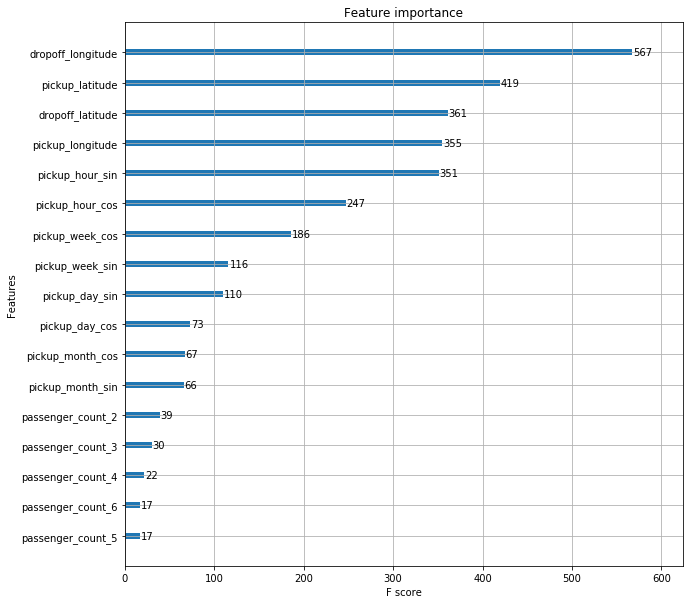

In [124]:
# plot feature importance
plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [125]:
# 2nd set of features : location (x,y,z) coordinates & time (as cyclical variables)
xg_reg2 = xgb.XGBRegressor(objective ='reg:linear',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 100,
                         seed=123)

In [127]:
xg_reg2.fit(X_train_coord, y_train_coord)
preds = xg_reg2.predict(X_test_coord)
rmse = np.sqrt(mean_squared_error(y_test_coord, preds))
print("RMSE: %f" % (rmse))

RMSE: 569.974529


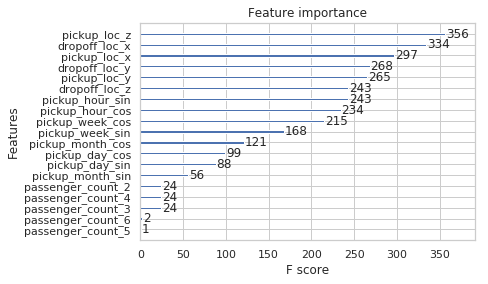

In [238]:
plot_importance(xg_reg2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [187]:
# 3rd set of features: location (longitude, latitude) & time (as categorical variable)
xg_reg3 = xgb.XGBRegressor(objective ='reg:linear',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 100,
                          seed=123)

In [188]:
xg_reg3.fit(X_train_time_cat_reg, y_train_time_cat_reg)
preds = xg_reg3.predict(X_test_time_cat_reg)
rmse = np.sqrt(mean_squared_error(y_test_time_cat_reg, preds))
print("RMSE: %f" % (rmse))

RMSE: 453.059598


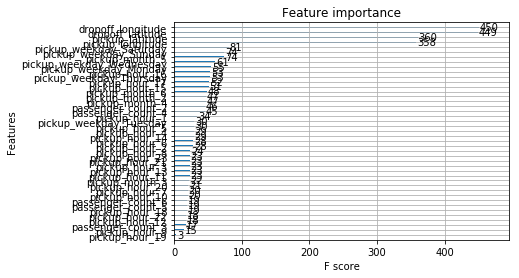

In [189]:
plot_importance(xg_reg3)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [190]:
# fourth set of features: location (x,y,z) coordinates & time (as categorical variable)
xg_reg4 = xgb.XGBRegressor(objective ='reg:linear',
                          colsample_bytree = 0.3,
                          learning_rate = 0.1,
                          max_depth = 5,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 100,
                          seed=123)

In [192]:
xg_reg4.fit(X_train_time_cat_coord, y_train_time_cat_coord)
preds = xg_reg4.predict(X_test_time_cat_coord)
rmse = np.sqrt(mean_squared_error(y_test_time_cat_coord, preds))
print("RMSE: %f" % (rmse))

RMSE: 572.207170


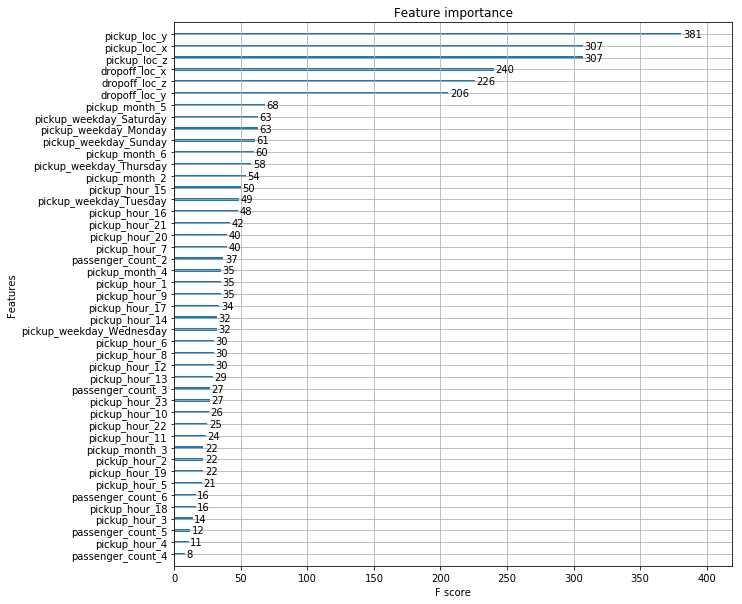

In [193]:
plot_importance(xg_reg4)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Using the location and latitude values as is gave a lower RMSE than the coordinate location features (x,y,z) in the base line model. Also, the categorical time variables gave a slightly higher RMSE value than the cyclical variables and , so we will proceed working the set features that contains the regular longitude and latitude values and the cylical time features since also the categorical time variables are more computationally expensive because they have a larger number of variables than the cyclical time features.   

**Conclusion**: the first set of features [ locaton (longitude, latitude) & time (as cyclical variables) ] gave a lower RMSE thus it will be used in the prediction model. 

After fine tuning the parameters, we expect that the RMSE is going to be lower

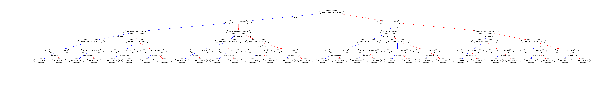

In [70]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [800, 10]
plt.show()

**Hyperparamater Tuning**

In this part, the different parameters of the xgboost tree are fine-tuned to give a lower RMSE value.

1. Optimize number of trees

In [ ]:
param_test1 = {
    'n_estimators': [100, 150, 200, 250, 300, 350]
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                                 max_depth=5,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 colsample_bytree=0.8,
                                                 objective= 'reg:linear',
                                                 nthread=7,
                                                 scale_pos_weight=1,
                                                 seed=27)
                        , param_grid=param_test1,scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)

In [99]:
gsearch1.best_params_

{'n_estimators': 350}

2. Tree Params grid 

In [131]:
# A parameter grid for XGBoost
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'max_depth': [6, 7],
              'min_child_weight': [4, 6],
              'gamma': [0,0.5],
              'subsample': [0.75, 0.8],
              'colsample_bytree': [ 0.8, 1.0],
              'silent': [1],
              'scale_pos_weight': [1],
              'n_estimators': [350]}


gsearch2 = GridSearchCV( XGBRegressor(learning_rate =0.1, seed=27),
                        param_grid=parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

gsearch2.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 114.9min
[Parallel(n_jobs=5)]: Done  64 out of  64 | elapsed: 187.6min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'n_estimators': [350], 'subsample': [0.75, 0.8], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.5], 'silent': [1], 'objective': ['reg:linear'], 'scale_pos_weight': [1], 'nthread': [4], 'min_child_weight': [4, 6], 'max_depth': [6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [133]:
print(gsearch2.best_params_)

{'colsample_bytree': 1.0, 'silent': 1, 'scale_pos_weight': 1, 'nthread': 4, 'min_child_weight': 6, 'n_estimators': 350, 'subsample': 0.8, 'objective': 'reg:linear', 'max_depth': 7, 'gamma': 0}


**Tuned XGboost**

In [135]:
tuned_xgb = xgb.XGBRegressor(objective ='reg:linear',
                          nthread = 4,
                          colsample_bytree = 1.0,
                          min_child_weight = 6,
                          learning_rate = 0.08,
                          subsample= 0.8,
                          max_depth = 7,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 350,
                          scale_pos_weight = 1,
                          seed=123)

In [137]:
tuned_xgb.fit(X_train_reg,y_train_reg)
preds = tuned_xgb.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
print("RMSE: %f" % (rmse))

RMSE: 306.109581


**Increase Number of Trees**

In [197]:
tuned_xgb2 = xgb.XGBRegressor(objective ='reg:linear',
                          nthread = 4,
                          colsample_bytree = 1.0,
                          min_child_weight = 6,
                          learning_rate = 0.08,
                          subsample= 0.8,
                          max_depth = 7,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 1000,
                          scale_pos_weight = 1,
                          seed=123)

In [198]:
tuned_xgb2.fit(X_train_reg,y_train_reg)


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, importance_type='gain',
       learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=6, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=True,
       subsample=0.8)

In [199]:
preds = tuned_xgb2.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
print("RMSE: %f" % (rmse))

RMSE: 297.038321


In [209]:
tuned_xgb3 = xgb.XGBRegressor(objective ='reg:linear',
                          nthread = 4,
                          colsample_bytree = 1.0,
                          min_child_weight = 6,
                          learning_rate = 0.08,
                          subsample= 0.8,
                          max_depth = 15,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 1200,
                          scale_pos_weight = 1,
                          seed=123)

In [210]:
tuned_xgb3.fit(X_train_reg,y_train_reg)
preds = tuned_xgb3.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
print("RMSE: %f" % (rmse))

RMSE: 283.204256


Improved the RMSE by almost **37%** after fine tunning

In [211]:
# save prediction model to a file
pickle.dump(tuned_xgb3, open("pima.pickle.dat", "wb"))

**Plot ML Predictions V.S Haversie Time**

In [228]:
# haversine time for the test set
test_haversine_time = data.iloc[X_test_reg.index]['haversine_time']
test_preds = preds

In [232]:
rmse_haversine = np.sqrt(mean_squared_error(y_test_reg, test_haversine_time))
print("RMSE Haversine: %f" % (rmse_haversine))

RMSE Haversine: 637.510032


In [233]:
rmse_ml = np.sqrt(mean_squared_error(y_test_reg, preds))
print("RMSE ML: %f" % (rmse_ml))

RMSE ML: 283.204256


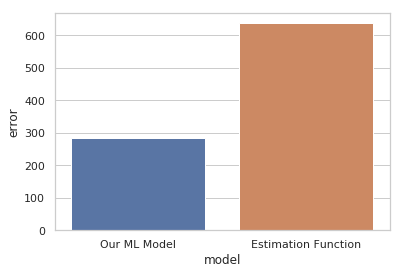

In [236]:
sns.set(style="whitegrid")
errors = pd.DataFrame({'model': ['Our ML Model', 'Estimation Function'], 'error': [rmse_ml, rmse_haversine]})
ax = sns.barplot(x="model", y="error", data=errors)

Our model performs better than the regular haversine estimation function by more than **50%**

**Learning Curves**

In this part, the bias and the varience of the prediction model is diagonosed by plotting the learning curve of the model with different training set sizes. 

In [142]:
# plots the validation & training scores 
def learning_curves(estimator, title, features, target, train_sizes, cv, n_jobs=-1):
    
    plt.figure(figsize = (14,5))
    # sklearn learning curve function
    train_sizes, train_scores, validation_scores = learning_curve(estimator, features, target, train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error',  n_jobs=n_jobs)
    
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.grid()
    
    plt.plot(train_sizes, train_scores_mean,'o-', color="r", label = 'Training error')
    
    plt.plot(train_sizes, validation_scores_mean,'o-', color="g", label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    
    title = 'Learning curves for a ' + title + ' model'
    plt.title(title, fontsize = 18, loc='left')
    
    plt.legend(loc="best")
    
    return plt

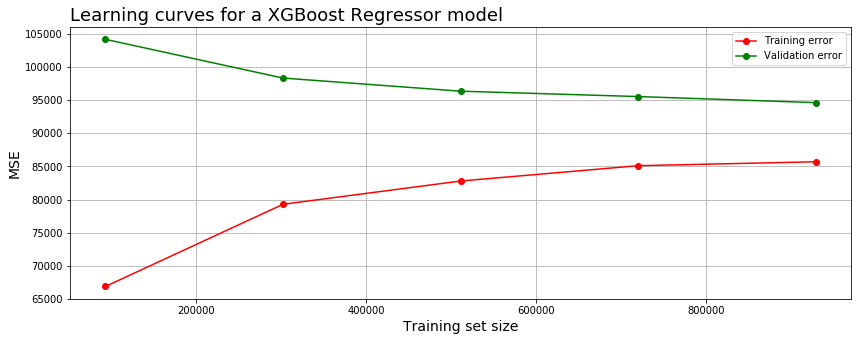

In [146]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=4)

learning_curves(xgb.XGBRegressor(objective ='reg:linear',
                          nthread = 4,
                          colsample_bytree = 1.0,
                          min_child_weight = 6,
                          learning_rate = 0.08,
                          subsample= 0.8,
                          max_depth = 7,
                          alpha = 10,
                          gamma = 0,
                          n_estimators = 350,
                          scale_pos_weight = 1,
                          seed=123), "XGBoost Regressor", X_train_reg, y_train_reg, train_sizes=np.linspace(.1, 1.0, 5), cv=cv, n_jobs=-1)

plt.show()


**Conclusion**

- Validation error starts out very hight but starts to improve as the training set size increases. However, the large gap at the end of the graph indicates that the model overfits the training data (low bias) at the end of training.
- The model still suffers from high varience because the training error is way less than the validation error. 
- To further improve the prediction results, new data shall be collected and incorporated in training the model. 

**Interpreting Model Prediction**

In [171]:
import shap   # used to explain model predictions

ImportError: cannot import name datasets

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(tuned_xgb)
shap_values = explainer.shap_values(X_train_reg)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])